In [60]:
import numpy as np 
import pandas as pd 

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression,RidgeCV,LassoCV,ElasticNetCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.metrics import r2_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import os

In [61]:
train=pd.read_csv("/Users/gardasnagarjun/Documents/5001-Ind/train.csv")
labels=train["playtime_forever"]
test=pd.read_csv("/Users/gardasnagarjun/Documents/5001-Ind/test.csv")
data=pd.concat([train,test],ignore_index=True)
data=data.drop("playtime_forever",1)

In [62]:
data.head()

,categories,genres,id,is_free,price,purchase_date,release_date,tags,total_negative_reviews,total_positive_reviews
0,"Single-player,Steam Trading Cards,Steam Cloud","Adventure,Casual,Indie",0,False,3700.0,"Jul 2, 2018","10 Dec, 2013","Indie,Adventure,Story Rich,Casual,Atmospheric,...",96.0,372.0
1,"Single-player,Partial Controller Support",RPG,1,True,0.0,"Nov 26, 2016","12 Aug, 2015","Mod,Utilities,RPG,Game Development,Singleplaye...",0.0,23.0
2,"Single-player,Full controller support,Steam Tr...","Adventure,Casual,Indie",2,False,5000.0,"Jul 2, 2018","28 Jan, 2014","Point & Click,Adventure,Story Rich,Comedy,Indi...",663.0,3018.0
3,"Single-player,Multi-player,Steam Achievements,...","Action,RPG",3,False,9900.0,"Nov 28, 2016","31 Mar, 2010","Medieval,RPG,Open World,Strategy,Sandbox,Actio...",1746.0,63078.0
4,"Single-player,Co-op,Steam Achievements,Full co...","Action,Indie,Strategy",4,False,4800.0,"Mar 4, 2018","30 Jul, 2012","Tower Defense,Co-op,Action,Strategy,Online Co-...",523.0,8841.0


In [63]:
#Null Values
data.isnull().sum(axis=0)

categories                0
genres                    0
id                        0
is_free                   0
price                     0
purchase_date             4
release_date              0
tags                      0
total_negative_reviews    4
total_positive_reviews    4
dtype: int64

In [64]:
data=data.fillna(value={"total_negative_reviews":data['total_negative_reviews'].mean(),
                                "total_positive_reviews":data['total_positive_reviews'].mean(),
                                "purchase_date":data['purchase_date'].mode()[0]})
data.isnull().sum(axis=0)

categories                0
genres                    0
id                        0
is_free                   0
price                     0
purchase_date             0
release_date              0
tags                      0
total_negative_reviews    0
total_positive_reviews    0
dtype: int64

In [65]:
#Adding 1 to change certain values of reviews from 0 to 1
data["total_negative_reviews"]=data["total_negative_reviews"]+1
data["total_positive_reviews"]=data["total_positive_reviews"]+1

In [66]:
data.head()

,categories,genres,id,is_free,price,purchase_date,release_date,tags,total_negative_reviews,total_positive_reviews
0,"Single-player,Steam Trading Cards,Steam Cloud","Adventure,Casual,Indie",0,False,3700.0,"Jul 2, 2018","10 Dec, 2013","Indie,Adventure,Story Rich,Casual,Atmospheric,...",97.0,373.0
1,"Single-player,Partial Controller Support",RPG,1,True,0.0,"Nov 26, 2016","12 Aug, 2015","Mod,Utilities,RPG,Game Development,Singleplaye...",1.0,24.0
2,"Single-player,Full controller support,Steam Tr...","Adventure,Casual,Indie",2,False,5000.0,"Jul 2, 2018","28 Jan, 2014","Point & Click,Adventure,Story Rich,Comedy,Indi...",664.0,3019.0
3,"Single-player,Multi-player,Steam Achievements,...","Action,RPG",3,False,9900.0,"Nov 28, 2016","31 Mar, 2010","Medieval,RPG,Open World,Strategy,Sandbox,Actio...",1747.0,63079.0
4,"Single-player,Co-op,Steam Achievements,Full co...","Action,Indie,Strategy",4,False,4800.0,"Mar 4, 2018","30 Jul, 2012","Tower Defense,Co-op,Action,Strategy,Online Co-...",524.0,8842.0


In [67]:
#Taking Genres as features (for now):
dataset=data.copy()
OE_genres=dataset['genres'].str.get_dummies(sep=',')
#OE_categors=dataset['categories'].str.get_dummies(sep=',')
#OE_tags=dataset['tags'].str.get_dummies(sep=',')
#Concating them to the dataset:
dataset=pd.concat([dataset,OE_genres],axis=1)
dataset.drop(['genres','categories','tags'],axis=1,inplace=True)
dataset.head()

,id,is_free,price,purchase_date,release_date,total_negative_reviews,total_positive_reviews,Action,Adventure,Animation & Modeling,...,Massively Multiplayer,Nudity,RPG,Racing,Sexual Content,Simulation,Sports,Strategy,Utilities,Violent
0,0,False,3700.0,"Jul 2, 2018","10 Dec, 2013",97.0,373.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,True,0.0,"Nov 26, 2016","12 Aug, 2015",1.0,24.0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,2,False,5000.0,"Jul 2, 2018","28 Jan, 2014",664.0,3019.0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,3,False,9900.0,"Nov 28, 2016","31 Mar, 2010",1747.0,63079.0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
4,4,False,4800.0,"Mar 4, 2018","30 Jul, 2012",524.0,8842.0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [68]:
#Review ratio (feature)
dataset['Review_ratio']=dataset["total_positive_reviews"]/dataset["total_negative_reviews"]
dataset.head()

,id,is_free,price,purchase_date,release_date,total_negative_reviews,total_positive_reviews,Action,Adventure,Animation & Modeling,...,Nudity,RPG,Racing,Sexual Content,Simulation,Sports,Strategy,Utilities,Violent,Review_ratio
0,0,False,3700.0,"Jul 2, 2018","10 Dec, 2013",97.0,373.0,0,1,0,...,0,0,0,0,0,0,0,0,0,3.845361
1,1,True,0.0,"Nov 26, 2016","12 Aug, 2015",1.0,24.0,0,0,0,...,0,1,0,0,0,0,0,0,0,24.000000
2,2,False,5000.0,"Jul 2, 2018","28 Jan, 2014",664.0,3019.0,0,1,0,...,0,0,0,0,0,0,0,0,0,4.546687
3,3,False,9900.0,"Nov 28, 2016","31 Mar, 2010",1747.0,63079.0,1,0,0,...,0,1,0,0,0,0,0,0,0,36.107041
4,4,False,4800.0,"Mar 4, 2018","30 Jul, 2012",524.0,8842.0,1,0,0,...,0,0,0,0,0,0,1,0,0,16.874046


In [69]:
#Converting purchase date to date format, We'll be using purchase date as a feature (for now)
purchase_date=pd.to_datetime(dataset["purchase_date"])
dataset.drop(["purchase_date","release_date"],axis=1,inplace=True)
dataset=pd.concat([dataset,purchase_date],axis=1)
dataset["purchase_date"]=dataset["purchase_date"].astype(np.int64)
dataset.head()

,id,is_free,price,total_negative_reviews,total_positive_reviews,Action,Adventure,Animation & Modeling,Audio Production,Casual,...,RPG,Racing,Sexual Content,Simulation,Sports,Strategy,Utilities,Violent,Review_ratio,purchase_date
0,0,False,3700.0,97.0,373.0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,3.845361,1530489600000000000
1,1,True,0.0,1.0,24.0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,24.000000,1480118400000000000
2,2,False,5000.0,664.0,3019.0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,4.546687,1530489600000000000
3,3,False,9900.0,1747.0,63079.0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,36.107041,1480291200000000000
4,4,False,4800.0,524.0,8842.0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,16.874046,1520121600000000000


In [70]:
#Removing unwanted columns:
dataset.drop(["total_negative_reviews","is_free","price","id"],axis=1,inplace=True)
dataset.head()

,total_positive_reviews,Action,Adventure,Animation & Modeling,Audio Production,Casual,Design & Illustration,Early Access,Free to Play,Gore,...,RPG,Racing,Sexual Content,Simulation,Sports,Strategy,Utilities,Violent,Review_ratio,purchase_date
0,373.0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,3.845361,1530489600000000000
1,24.0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,24.000000,1480118400000000000
2,3019.0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,4.546687,1530489600000000000
3,63079.0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,36.107041,1480291200000000000
4,8842.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,16.874046,1520121600000000000


In [71]:
#Splitting the Data into its original training and test data
train_data = dataset.loc[:356, :]
predict_data = dataset.loc[357:]
predict_data.reset_index(drop=True, inplace=True)

In [72]:
train_data

,total_positive_reviews,Action,Adventure,Animation & Modeling,Audio Production,Casual,Design & Illustration,Early Access,Free to Play,Gore,...,RPG,Racing,Sexual Content,Simulation,Sports,Strategy,Utilities,Violent,Review_ratio,purchase_date
0,373.0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,3.845361,1530489600000000000
1,24.0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,24.000000,1480118400000000000
2,3019.0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,4.546687,1530489600000000000
3,63079.0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,36.107041,1480291200000000000
4,8842.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,16.874046,1520121600000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,151.0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1.641304,1511481600000000000
353,19009.0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3.919381,1534291200000000000
354,5100.0,1,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,2.965116,1517270400000000000
355,719.0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4.493750,1506124800000000000


In [73]:
predict_data

,total_positive_reviews,Action,Adventure,Animation & Modeling,Audio Production,Casual,Design & Illustration,Early Access,Free to Play,Gore,...,RPG,Racing,Sexual Content,Simulation,Sports,Strategy,Utilities,Violent,Review_ratio,purchase_date
0,2608.0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2.322351,1540684800000000000
1,5763.0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,2.577370,1563580800000000000
2,688.0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,5.134328,1563235200000000000
3,68.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1.700000,1517270400000000000
4,40345.0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,10.877595,1487894400000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,9335.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,18.056093,1521763200000000000
86,1246.0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,7.039548,1520035200000000000
87,33129.0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,5.216344,1518912000000000000
88,6.0,1,1,0,0,0,0,0,0,0,...,1,0,0,1,1,1,0,0,6.000000,1511049600000000000


In [106]:
features=train_data
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(features,labels,test_size=0.3,random_state=0)
print (x_train.shape, y_train.shape)
print (x_test.shape, y_test.shape)

(249, 23) (249,)
(108, 23) (108,)


In [119]:
rf=RandomForestRegressor(n_estimators=1000,max_depth=200,random_state=36)
rf.fit(x_train,y_train)
predict_y = rf.predict(x_train).clip(min=0)
print("training error:",np.sqrt(mean_squared_error(y_train, predict_y)))

predict_y = rf.predict(x_test).clip(min=0)
print("testing error:", np.sqrt(mean_squared_error(y_test, predict_y)))

training error: 3.5537435199093754
testing error: 14.281803274483478


In [120]:
predict_submission=rf.predict(predict_data).clip(min=0)
submission = pd.read_csv("/Users/gardasnagarjun/Documents/5001-Ind/Submission/samplesubmission.csv")
submission["playtime_forever"] = predict_submission
output_file="/Users/gardasnagarjun/Documents/5001-Ind/Submission/submission_RFR(Refined).csv"
submission.to_csv(output_file, index=False)

In [77]:
#Log Transformation of the label and Checking:
labels_log=np.log(labels+1)

In [78]:
from sklearn.model_selection import train_test_split
x_train_log,x_test_log,y_train_log,y_test_log=train_test_split(features,labels_log,test_size=0.2,random_state=0)
print (x_train.shape, y_train.shape)
print (x_test.shape, y_test.shape)

(285, 23) (285,)
(72, 23) (72,)


In [79]:
rf1=RandomForestRegressor(n_estimators=1000,max_depth=200,random_state=36)
rf1.fit(x_train_log,y_train_log)
predict_y = rf1.predict(x_train_log).clip(min=0)
print("training error:",np.sqrt(mean_squared_error(y_train_log, predict_y)))

predict_y = rf1.predict(x_test_log).clip(min=0)
print("testing error:", np.sqrt(mean_squared_error(y_test_log, predict_y)))

training error: 0.316904735705515
testing error: 0.85329445369109


In [80]:
predict_submission=rf1.predict(predict_data).clip(min=0)
submission = pd.read_csv("/Users/gardasnagarjun/Documents/5001-Ind/Submission/samplesubmission.csv")
submission["playtime_forever"] = predict_submission
output_file="/Users/gardasnagarjun/Documents/5001-Ind/Submission/submission_RFR(Refined_Log).csv"
submission.to_csv(output_file,index=False)
#Getting low score at the leaderboard

In [81]:
# This time with PCA:
from sklearn.decomposition import PCA
comp=features.shape[0]
pca=PCA(n_components=23)
X_scaled_pca=pca.fit_transform(features)
test_X_scaled_pca = pca.transform(predict_data)

In [82]:
X_scaled_pca

array([[-8.86628571e+15, -1.35169710e+04, -5.44536930e+00, ...,
        -2.41483433e-03,  3.14655895e-03,  1.83289926e-17],
       [ 4.15049143e+16, -2.21745090e+04,  1.27620090e+01, ...,
        -9.52389437e-03, -6.82275340e-03, -2.07879609e-18],
       [-8.86628571e+15, -1.08709710e+04, -4.86295682e+00, ...,
        -2.16951077e-03,  3.30113644e-03,  2.16919625e-17],
       ...,
       [ 4.35291429e+15, -1.09704281e+04, -7.05967091e+00, ...,
        -7.98290340e-04,  1.20402121e-03,  8.34474747e-19],
       [ 1.54985143e+16, -1.71898526e+04, -5.76374477e+00, ...,
        -5.50032191e-03, -2.90078471e-03, -1.56177041e-19],
       [ 1.41531429e+15, -1.46698818e+04, -8.29204724e-01, ...,
        -3.09160858e-03, -9.51593308e-03,  2.44639920e-18]])

In [132]:
from sklearn.model_selection import train_test_split
x_train_pca,x_test_pca,y_train_pca,y_test_pca=train_test_split(X_scaled_pca,labels,test_size=0.3,random_state=0)
print (x_train_pca.shape, y_train_pca.shape)
print (x_test_pca.shape, y_test_pca.shape)

(249, 23) (249,)
(108, 23) (108,)


In [84]:
rf2=RandomForestRegressor(n_estimators=1000,max_depth=200,random_state=36)
rf2.fit(x_train_pca,y_train_pca)
predict_y = rf2.predict(x_train_pca).clip(min=0)
print("training error:",np.sqrt(mean_squared_error(y_train_pca, predict_y)))

predict_y = rf2.predict(x_test_pca).clip(min=0)
print("testing error:", np.sqrt(mean_squared_error(y_test_pca, predict_y)))

training error: 4.852235771972524
testing error: 9.08923935183288


In [85]:
predict_submission=rf2.predict(predict_data).clip(min=0)
submission = pd.read_csv("/Users/gardasnagarjun/Documents/5001-Ind/Submission/samplesubmission.csv")
submission["playtime_forever"] = predict_submission
output_file="/Users/gardasnagarjun/Documents/5001-Ind/Submission/submission_RFR(Refined_PCA).csv"
submission.to_csv(output_file, index=False)
#This too getting low score at the leaderboard
#Try this again

In [86]:
#Try AdaBoost:
ada=AdaBoostRegressor()
ada.fit(x_train,y_train)
predict_y = ada.predict(x_train).clip(min=0)
print("training error:",np.sqrt(mean_squared_error(y_train, predict_y)))

predict_y = ada.predict(x_test).clip(min=0)
print("testing error:", np.sqrt(mean_squared_error(y_test, predict_y)))

training error: 6.167379845779167
testing error: 8.866538021850888


In [87]:
predict_submission=ada.predict(predict_data).clip(min=0)
submission = pd.read_csv("/Users/gardasnagarjun/Documents/5001-Ind/Submission/samplesubmission.csv")
submission["playtime_forever"] = predict_submission
output_file="/Users/gardasnagarjun/Documents/5001-Ind/Submission/submission_ADA(Refined).csv"
submission.to_csv(output_file, index=False)
submission.to_csv("submission_ADA(Refined).csv", index=False)

In [88]:
#Using GridSearchCV:
param_grid = [{'max_depth':[10, 20, 30, 40, 50, 60, 70, 80, 100], 
                     'max_leaf_nodes':[10, 50, 100, 200], 
                     'n_estimators': [10,20, 30, 40, 50]}]
tuned_model = GridSearchCV(RandomForestRegressor(), param_grid, cv=5,n_jobs=-1,
                   scoring='neg_mean_squared_error')

tuned_model.fit(x_train, y_train)
predict_y = tuned_model.predict(x_train).clip(min=0)
print("training error:",np.sqrt(mean_squared_error(y_train, predict_y)))

predict_y = tuned_model.predict(x_test).clip(min=0)
print("testing error:", np.sqrt(mean_squared_error(y_test, predict_y)))


training error: 5.786202527219994
testing error: 10.257104948091404


In [89]:
predict_submission=tuned_model.predict(predict_data).clip(min=0)
submission = pd.read_csv("/Users/gardasnagarjun/Documents/5001-Ind/Submission/samplesubmission.csv")
submission["playtime_forever"] = predict_submission
output_file="/Users/gardasnagarjun/Documents/5001-Ind/Submission/submission_RFR(Refined_GridCV).csv"
submission.to_csv(output_file, index=False)

In [115]:
#XGboost Regressor:
import xgboost as xgb
xg_reg = xgb.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 n_estimators=1000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.48,
                 subsample=0.6,
                 seed=22)
xg_reg.fit(x_train,y_train)
pred_y = xg_reg.predict(x_train).clip(min=0)
print("training error:",np.sqrt(mean_squared_error(y_train, pred_y)))

pred_y = xg_reg.predict(x_test).clip(min=0)
print("testing error:", np.sqrt(mean_squared_error(y_test, pred_y)))

[10:40:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
training error: 0.4943809746350216
testing error: 14.491001359316245


In [116]:
predict_submission=xg_reg.predict(predict_data).clip(min=0)
submission = pd.read_csv("/Users/gardasnagarjun/Documents/5001-Ind/Submission/samplesubmission.csv")
submission["playtime_forever"] = predict_submission
output_file="/Users/gardasnagarjun/Documents/5001-Ind/Submission/submission_XGB(Refined).csv"
submission.to_csv(output_file, index=False)

In [133]:
from sklearn.model_selection import cross_val_score
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, x_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)


In [134]:
n_estimators = [170, 200, 250, 300]
cv_rmse_br = [rmse_cv(BaggingRegressor(n_estimators = n_estimator)).mean() 
            for n_estimator in n_estimators]
print (cv_rmse_br)

[8.865834072784295, 8.851035799323991, 8.764751007749583, 8.768939364567336]


Text(0, 0.5, 'rmse')

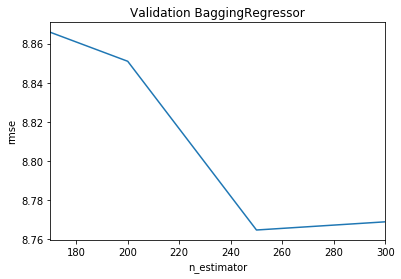

In [135]:
cv_br = pd.Series(cv_rmse_br , index = n_estimators)
cv_br.plot(title = "Validation BaggingRegressor")
plt.xlabel("n_estimator")
plt.ylabel("rmse")

In [136]:
#PassiveAggresive Regressor:
model_br = BaggingRegressor(n_estimators = 170)
model_br.fit(x_train,y_train)
pred_y = model_br.predict(x_train).clip(min=0)
print("training error:",np.sqrt(mean_squared_error(y_train, pred_y)))

pred_y = model_br.predict(x_test).clip(min=0)
print("testing error:", np.sqrt(mean_squared_error(y_test, pred_y)))

training error: 3.4227609871472864
testing error: 14.302683101241223


In [137]:
predict_submission=model_br.predict(predict_data).clip(min=0)
submission = pd.read_csv("/Users/gardasnagarjun/Documents/5001-Ind/Submission/samplesubmission.csv")
submission["playtime_forever"] = predict_submission
output_file="/Users/gardasnagarjun/Documents/5001-Ind/Submission/submission_Bagging(Refined).csv"
submission.to_csv(output_file, index=False)